In [1]:
import uproot as uproot

import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.cuda.amp import GradScaler

from torchvision.models import resnet18

from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt

import re

# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter('runs/ecal-experiment-4')

In [2]:
# %tensorboard --logdir=runs

In [201]:
# data_path = 'data/0001_64k_wpc_25x25_spot_rs42.root'
# data_path = 'data/0001_64k_wpc_15x15_spot.root'
# data_path = 'data/0001_64k_real_spectra_15x15_spot.root'
data_path = "data/0001_64k_wpc_10x10_spot_v2.root"
# data_path = "data/0001_64k_wpc_20x20_spot.root"
# data_path = "data/0001_64k_wpc_40x40_spot_rs42.root"

root_file = uproot.open(data_path)
nevents=None

def extract_dimensions(filename):
    match = re.search(r'\d+x\d+', filename)
    if match:
        dimensions = match.group(0)
        x, y = dimensions.split('x')
        return int(x), int(y)
    else:
        return None

height, width = extract_dimensions(data_path)

# Наблюдаемые величины
RawE = root_file['ecalNT']['RawEnergyDeposit'].arrays(library='np')['RawEnergyDeposit'][:nevents]
x = root_file['ecalNT']['RawX'].arrays(library='np')['RawX'][:nevents]
y = root_file['ecalNT']['RawY'].arrays(library='np')['RawY'][:nevents]
z = root_file['ecalNT']['RawZ'].arrays(library='np')['RawZ'][:nevents]
# EnergyDeposit = [img.reshape(15,15)[None,:,:] for img in np.array(root_file['ecalNT']['EnergyDeposit'].array()[:nevents])]

EnergyDeposit = np.array(root_file['ecalNT']['EnergyDeposit'].array()[:nevents])
EnergyDeposit = EnergyDeposit.reshape(-1, height, width)[:, None, :, :]

# Величины на входе симулятора
ParticlePDG = np.array(root_file['ecalNT']['ParticlePDG'].array())[:nevents]
ParticleMomentum_v = np.array(root_file['ecalNT']['ParticleMomentum'].array())[:nevents]
ParticleMomentum = np.sum(ParticleMomentum_v * ParticleMomentum_v, axis=1) ** 0.5

ParticlePoint = np.array(root_file['ecalNT']['ParticlePoint'].array())[:nevents]

In [111]:
ParticleMomentum_v

array([[ 0.        ,  0.        , 13.91854867],
       [ 0.        ,  0.        , 65.4043075 ],
       [ 0.        ,  0.        , 13.7113234 ],
       ...,
       [ 0.        ,  0.        ,  9.7126344 ],
       [ 0.        ,  0.        , 69.21108902],
       [ 0.        ,  0.        , 71.30250799]])

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda', index=0)

In [17]:
from data import Normalizer

X = np.array(EnergyDeposit)
y = np.concatenate((ParticleMomentum[:, None], ParticlePoint[:, :2]), axis=1)

# X = X[y < 10]
# y = y[y < 10]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

x_normalizer = Normalizer()
y_normalizer = Normalizer()

x_normalizer.fit(y_train[:, 1])
y_train[:, 1] = x_normalizer.transform(y_train[:, 1])
y_val[:, 1] = x_normalizer.transform(y_val[:, 1])

y_normalizer.fit(y_train[:, 2])
y_train[:, 2] = y_normalizer.transform(y_train[:, 2])
y_val[:, 2] = y_normalizer.transform(y_val[:, 2])

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


train_generator = torch.Generator()
train_generator.manual_seed(0)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=0, worker_init_fn=seed_worker, generator=train_generator)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=True, num_workers=0)

In [60]:
ParticlePoint[id, :2]

array([-0.00409777, -0.3870825 ])

Energy: 32.9994 || Position: [2.09588441 0.6770446 ]


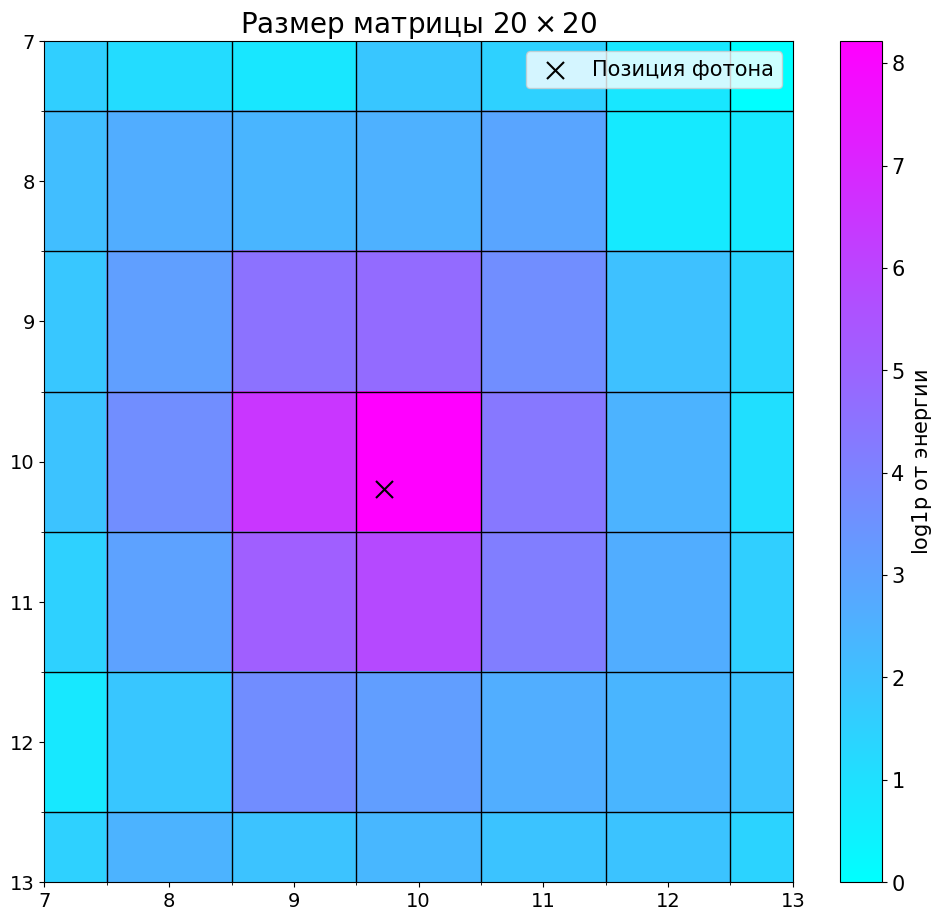

In [200]:
id = 1

data = EnergyDeposit[id][0]
trg = ParticlePoint[id, :2]
print(f"Energy: {ParticleMomentum[id]:.4f} || Position: {trg}")

data = np.log1p(data)

plt.figure(figsize=(10, 9))
plt.imshow(data, cmap='cool', interpolation='nearest', aspect='auto')

# for i in range(data.shape[0]):
#     for j in range(data.shape[1]):
#         text = plt.text(j, i, f"{data[i, j]:.2f}", ha="center", va="center", color="black")

sensor_size = 60.6

image_height, image_width = data.shape
cell_size = sensor_size / image_height

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label("$\\mathsf{log1p}$ от энергии", fontsize=15)

plt.scatter(trg[1] / cell_size + (image_height - 1) / 2, trg[0] / cell_size + (image_width - 1) / 2, color='black', marker='x', s=150.0, label='Позиция фотона')

plt.xticks(list(range(data.shape[0])), fontsize=14)
plt.yticks(list(range(data.shape[1])), fontsize=14)

plt.tight_layout()
plt.title(f"Размер матрицы ${data.shape[0]} \\times {data.shape[1]}$", fontsize=20)
plt.legend(fontsize=15)

ax=plt.gca()
ax.set_xticks([x-0.5 for x in range(1,image_height)], minor=True)
ax.set_yticks([y-0.5 for y in range(1,image_width)], minor=True)

plt.grid(True, which='minor', color='black', linestyle='-', linewidth=1)

plt.savefig(f"../report/graphics/data_{image_height}x{image_width}", bbox_inches='tight')

x_min = image_height / 2 - 3
x_max = image_height / 2 + 3

plt.axis([x_min, x_max, x_max, x_min])

plt.savefig(f"../report/graphics/data_{image_height}x{image_width}_zoomed", bbox_inches='tight')

plt.show()

Energy: 13.7113 || Position: [2.03503479 5.69448127]


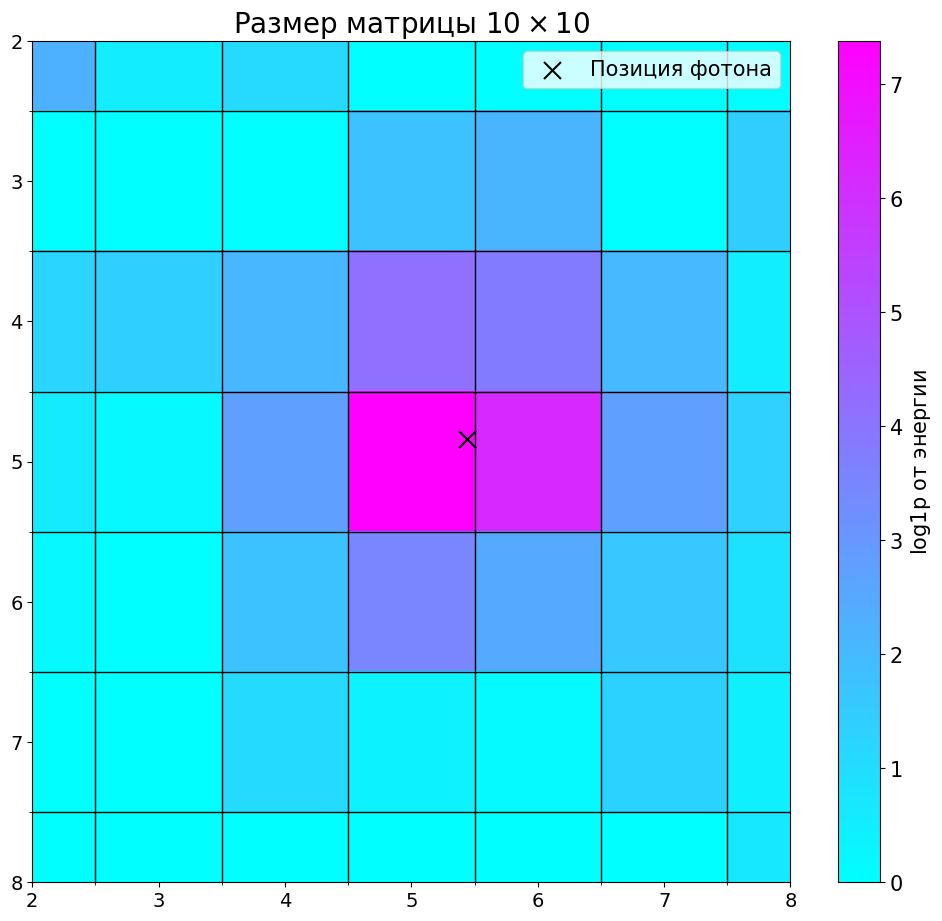

In [207]:
id = 2

data = EnergyDeposit[id][0]
trg = ParticlePoint[id, :2]
print(f"Energy: {ParticleMomentum[id]:.4f} || Position: {trg}")

data = np.log1p(data)

plt.figure(figsize=(10, 9))
plt.imshow(data, cmap='cool', interpolation='nearest', aspect='auto')

# for i in range(data.shape[0]):
#     for j in range(data.shape[1]):
#         text = plt.text(j, i, f"{data[i, j]:.2f}", ha="center", va="center", color="black")

sensor_size = 60.6

image_height, image_width = data.shape
cell_size = sensor_size / image_height

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label("$\\mathsf{log1p}$ от энергии", fontsize=15)

plt.scatter(trg[1] / cell_size + (image_height - 1) / 2, trg[0] / cell_size + (image_width - 1) / 2, color='black', marker='x', s=150.0, label='Позиция фотона')

plt.xticks(list(range(data.shape[0])), fontsize=14)
plt.yticks(list(range(data.shape[1])), fontsize=14)

plt.tight_layout()
plt.title(f"Размер матрицы ${data.shape[0]} \\times {data.shape[1]}$", fontsize=20)
plt.legend(fontsize=15)

ax=plt.gca()
ax.set_xticks([x-0.5 for x in range(1,image_height)], minor=True)
ax.set_yticks([y-0.5 for y in range(1,image_width)], minor=True)

plt.grid(True, which='minor', color='black', linestyle='-', linewidth=1)

plt.savefig(f"../report/graphics/data_{image_height}x{image_width}", bbox_inches='tight')

x_min = image_height / 2 - 3
x_max = image_height / 2 + 3

plt.axis([x_min, x_max, x_max, x_min])

plt.savefig(f"../report/graphics/data_{image_height}x{image_width}_zoomed", bbox_inches='tight')

plt.show()

In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
from model import AnaModel

model = AnaModel(
    height=height,
    width=width,
    positive_eng=True,
    positive_pos=False,
    normalize_position=True,
)

model(data.unsqueeze(0))[0, 1:]

tensor([ 0.2627, -0.9009], grad_fn=<SliceBackward0>)

In [118]:
F.softplus(torch.tensor([0.1604]))

tensor([0.7766])

0 tensor(0.5642) tensor(0.9222) tensor(0.5642) tensor(0.9222)
tensor([39.2763,  0.5642,  0.9222])


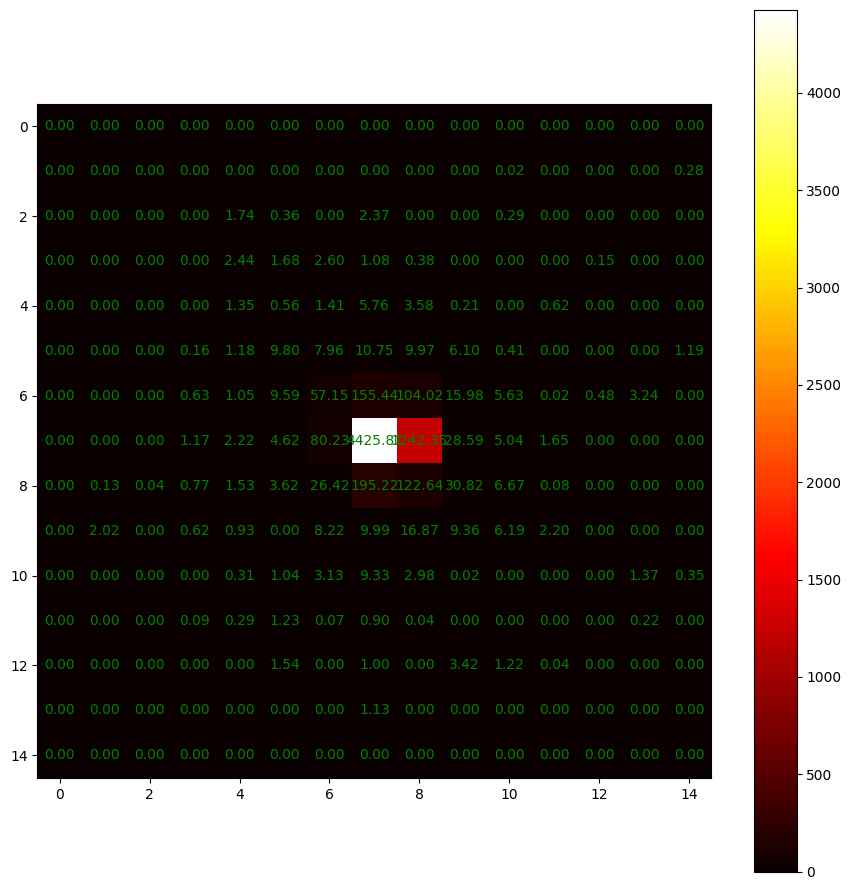

In [124]:
class MyRandomRotation(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x, y):
        assert x.shape[-1] % 2 == 1, "The shape of the image must be odd"
        k = torch.randint(0, 4, (1,)).item()
        x = torch.rot90(x, k, (1, 2))
        if k == 0:
            new_y1, new_y2 = y[1], y[2]
        elif k == 1:
            new_y1, new_y2 = 1 - y[2], y[1]
        elif k == 2:
            new_y1, new_y2 = 1 - y[1], 1 - y[2]
        elif k == 3:
            new_y1, new_y2 = y[2], 1 - y[1]
        print(k, y[1], y[2], new_y1, new_y2)
        new_y1 = torch.clone(new_y1)
        new_y2 = torch.clone(new_y2)
        y[1] = new_y1
        y[2] = new_y2
        return x, y

data = torch.clone(init_data)
trg = torch.clone(init_trg)

data, trg = MyRandomRotation()(data[None, :, :], trg)

data = data[0]

print(trg)

plt.figure(figsize=(9, 9))
plt.imshow(data, cmap='hot', interpolation='nearest')
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        text = plt.text(j, i, f"{data[i, j]:.2f}",
                        ha="center", va="center", color="green")

plt.colorbar()
plt.tight_layout()
plt.show()

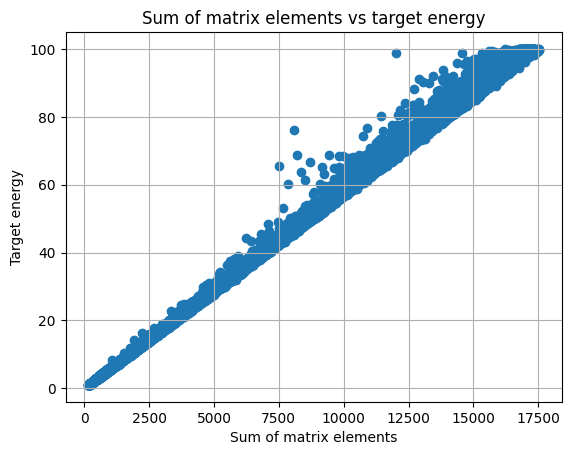

In [36]:
plt.scatter(X_train.sum(axis=(1, 2, 3)), y_train)
plt.grid()
plt.title("Sum of matrix elements vs target energy")
plt.xlabel("Sum of matrix elements")
plt.ylabel("Target energy")

plt.show()

In [37]:
# torch.autograd.set_detect_anomaly(True)

In [38]:
class SimpleModel(nn.Module):
    def __init__(self, height=15, width=15) -> None:
        super(SimpleModel, self).__init__()

        self.height = height
        self.width = width

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.GELU(),
        )

        self.fc1 = nn.Linear(3600, 1)
    
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 1, self.height, self.width)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = x.flatten()
        return x

In [39]:
class LinearModel(nn.Module):
    def __init__(self, height=15, width=15, output_positive=False, eps=1e-9) -> None:
        super(LinearModel, self).__init__()

        self.height = height
        self.width = width

        self.fc1 = nn.Linear(self.height * self.width, 1)
        self.output_positive = output_positive
        self.eps = eps
    
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, self.height * self.width)
        x = self.fc1(x)
        x = x.flatten()
        # print(f"Model: {torch.max(x)}")
        if self.output_positive:
            x = F.softplus(x)
        # print(f"Model: {torch.max(x)}")
        return x

In [40]:
class MyModel(nn.Module):
    def __init__(self, height=15, width=15, n_scales=7, hidden_dim=4, output_positive=True) -> None:
        super(MyModel, self).__init__()

        self.height = height
        self.width = width

        self.output_positive = output_positive

        self.n_scales = n_scales
        self.hidden_dim = hidden_dim
        self.scales = [0.5 ** i for i in range(self.n_scales)]

        self.models = []
        for scale in self.scales:
            self.models.append(self._get_model())

        self.models = nn.ModuleList(self.models)
        
        self.fc_last = nn.Linear(self.n_scales * self.hidden_dim, 1)
    
    def _get_model(self):
        layer = nn.Sequential(
            nn.Linear(self.height * self.width, self.hidden_dim),
            nn.GELU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
        )
        return layer

        # return nn.Linear(self.height * self.width, self.hidden_dim)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, self.height * self.width)
        
        result = None
        for scale, model in zip(self.scales, self.models):
            current = model(x * scale) / scale
            if result is None:
                result = current
            else:
                result = torch.cat((result, current), dim=1)

        # result = self.fc_last(result)
        result = result.mean(dim=1)

        if self.output_positive:
            result = F.softplus(result)
        return result

In [41]:
class MyResnet18(nn.Module):
    def __init__(self, height=15, width=15, remove_batch_norm=True, output_positive=True) -> None:
        super(MyResnet18, self).__init__()

        self.height = height
        self.width = width

        self.output_positive = output_positive

        self.model = resnet18(num_classes=1)
        self.model.conv1 = nn.Conv2d(1, 64, 1, bias=False)

        if remove_batch_norm:
            self._remove_batch_norms(self.model)

    def _remove_batch_norms(self, module):
        for name, child in module.named_children():
            if isinstance(child, nn.BatchNorm2d):
                identity_layer = nn.Identity()
                setattr(module, name, identity_layer)
            else:
                self._remove_batch_norms(child)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 1, self.height, self.width)
        
        result = self.model(x)

        if self.output_positive:
            result = F.softplus(result)
        return result

In [42]:
def train_fn(train_loader, val_loader, model, optimizer, lr_scheduler, criterion, num_epochs, device, log_freq=None, max_grad_norm=20):

    def get_lr(optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']

    train_loss = []
    train_batch_idx = []
    train_num_batches = 0

    val_loss = []
    
    pbar = tqdm(range(1, num_epochs + 1))

    for epoch in pbar:
        epoch_loss = torch.zeros((1,), device=device, dtype=torch.float32)
        num_batches = 0
        model.train()
        for data, trg in train_loader:
            train_num_batches += 1
            num_batches += 1
            optimizer.zero_grad()

            data = data.to(device)
            trg = trg.to(device)

            output = model(data)
            loss = criterion(output, trg, 1 / trg)

            epoch_loss += loss.detach()

            loss.backward()

            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            # writer.add_scalar('Training loss', loss.item(), train_num_batches)
            # writer.add_scalar('Model gradient norm', grad_norm.item(), train_num_batches)
            # writer.add_scalar('Learning rate', get_lr(optimizer), train_num_batches)

            if log_freq is not None and train_num_batches % log_freq == 0:
                train_batch_idx.append(train_num_batches)
                train_loss.append((epoch_loss / num_batches).item())
                clear_output(True)

                plt.figure(figsize=(15, 7))

                plt.subplot(1, 2, 1)
                plt.plot(train_batch_idx, train_loss)
                plt.xlabel("Batch index")
                plt.ylabel("Loss")
                plt.grid()
                plt.title("Train loss")

                plt.subplot(1, 2, 2)
                plt.plot(list(range(1, epoch)), val_loss)
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.grid()
                plt.title("Validation loss")

                plt.show()
                print(f"Epoch: {epoch}/{num_epochs} || Batch: {num_batches}/{len(train_loader)} || Train loss: {epoch_loss.item() / num_batches:0.4f} || Val loss: {(val_loss[-1] if val_loss else -1.0):0.4f}")
        
        cur_loss = torch.zeros((1,), device=device, dtype=torch.float32)
        model.eval()
        with torch.no_grad():
            for data, trg in val_loader:
                data = data.to(device)
                trg = trg.to(device)

                output = model(data)
                cur_loss += criterion(output, trg, 1 / trg).detach()
        
        cur_loss /= len(val_loader)

        val_loss.append(cur_loss.item())
        # writer.add_scalar('Validation loss', cur_loss.item(), epoch)

        if lr_scheduler is not None:
            lr_scheduler.step()
    
    return train_loss, train_batch_idx

In [43]:
def loss_fn_1(pred, trg, weights, eps=1e-9, reduction='mean'):
    loss = torch.sqrt(F.mse_loss(pred, trg, reduction='none') + eps) * weights
    if reduction == 'mean':
        loss = loss.mean()
    return loss

def loss_fn_2(pred, trg, weights, eps=1e-9, reduction='mean'):
    loss = ((pred - trg) * weights) ** 2
    if reduction == 'mean':
        loss = loss.mean()
    loss = torch.sqrt(loss)
    return loss

def loss_fn_3(pred, trg, weights):
    return F.mse_loss(pred, trg)

def loss_fn_4(pred, trg, weights, eps=1e-9):
    return torch.sqrt(F.mse_loss(torch.log(pred + 1), torch.log(trg + 1)))

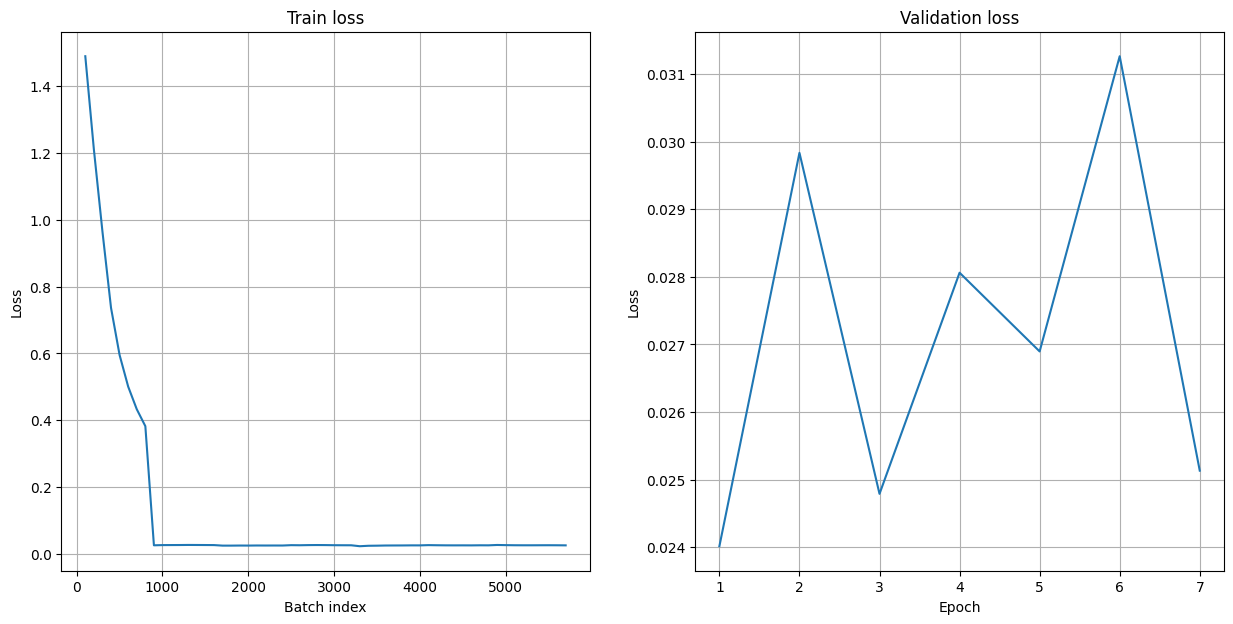

In [44]:
# model = MyModel(
#     height=train_dataset[0][0].shape[-2],
#     width=train_dataset[0][0].shape[-1],
#     n_scales=10,
#     hidden_dim=64,
#     output_positive=True,
# ).to(device)

model = LinearModel(
    height=train_dataset[0][0].shape[-2],
    width=train_dataset[0][0].shape[-1],
    output_positive=True,
).to(device)

# model = MyResnet18(
#     height=train_dataset[0][0].shape[-2],
#     width=train_dataset[0][0].shape[-1],
#     remove_batch_norm=False,
#     output_positive=False,
# ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=3e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 15, 0.8)
criterion = loss_fn_2
num_epochs = 100

train_loss, train_batch_idx = train_fn(
    train_loader=train_loader,
    val_loader=val_loader,
    model=model,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    log_freq=100,
    max_grad_norm=20,
)

In [108]:
def collect_losses(model, val_loader, loss_fn, device):
    trg_vals, loss_vals = [], []
    model.eval()
    all_outputs = torch.zeros((0,), device=device)
    all_targets = torch.zeros((0,), device=device)
    with torch.no_grad():
        for data, trg in val_loader:
            data = data.to(device)
            trg = trg.to(device)

            output = model(data)

            all_outputs = torch.cat((all_outputs, output), dim=0)
            all_targets = torch.cat((all_targets, trg), dim=0)

            loss = loss_fn(output, trg, 1 / trg, reduction='none').detach()
            trg_vals += trg.cpu().numpy().tolist()
            loss_vals += loss.cpu().numpy().tolist()
        
        total_loss = loss_fn(all_outputs, all_targets, 1 / all_targets).detach()
    return trg_vals, loss_vals, total_loss

val_trg, val_loss, total_loss = collect_losses(model, val_loader, loss_fn_2, device)

print(f"RMSE/E loss on validation: {total_loss:0.4f}")

RMSE/E loss on validation: 0.6910


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (12802,) + inhomogeneous part.

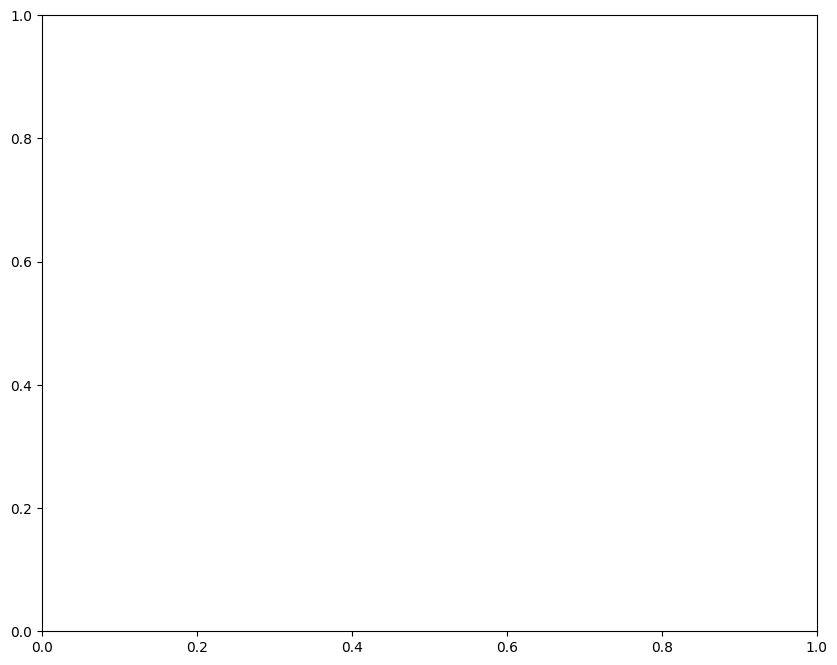

In [107]:
plt.figure(figsize=(10, 8))
plt.scatter(val_trg, val_loss, s=10)
plt.title('Loss on validation set')
plt.xlabel('Momentum')
plt.ylabel('Loss')
plt.yticks(np.linspace(0.0, 0.4, 21))
plt.xticks(np.linspace(0.0, 500.0, 21))
plt.grid()
plt.show()

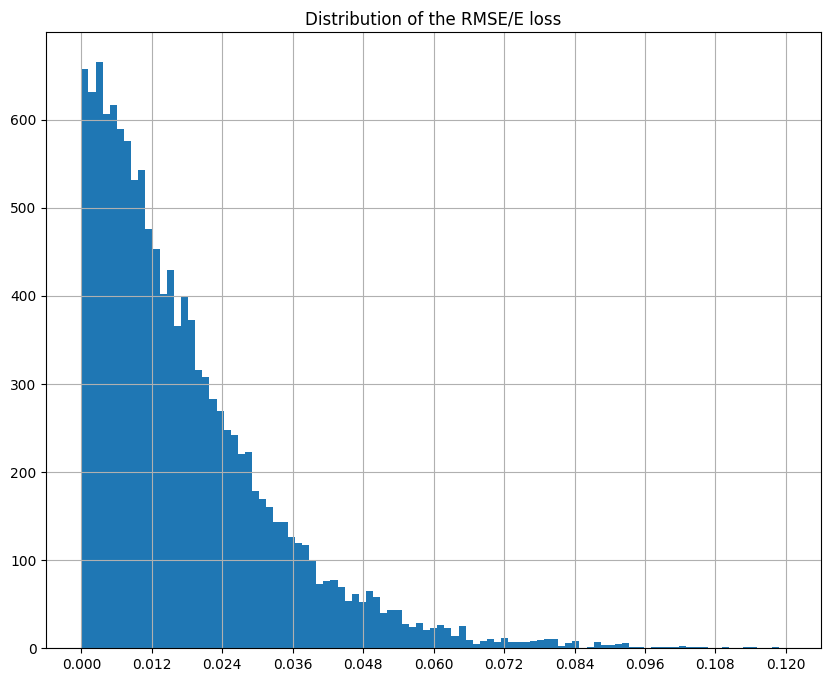

In [24]:
plt.figure(figsize=(10, 8))
plt.hist(val_loss, bins=np.linspace(0, 0.12, 100))
plt.xticks(np.linspace(0, 0.12, 11))
plt.grid()
plt.title("Distribution of the RMSE/E loss")

plt.show()

KeyboardInterrupt: 

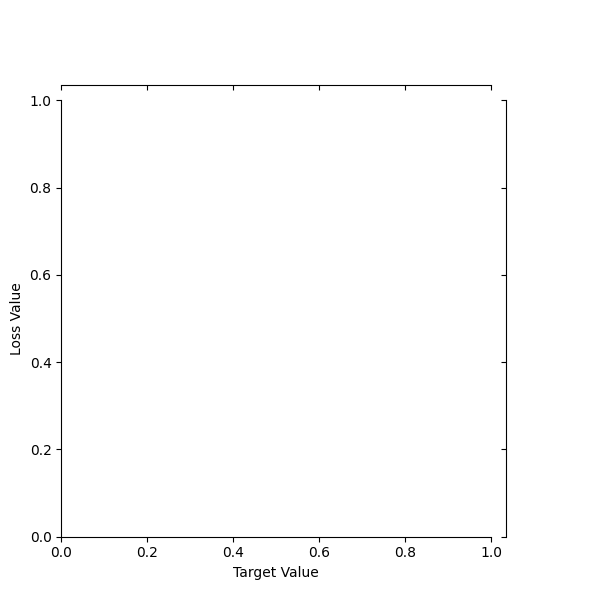

In [216]:
data = pd.DataFrame({'Target Value': val_trg, 'Loss Value': val_loss})

sns.jointplot(data=data, x='Target Value', y='Loss Value', kind='kde', fill=True)

sns.scatterplot(data=data, x='Target Value', y='Loss Value', color='r', alpha=0.1, size=1)

plt.yticks(np.linspace(0.0, 0.4, 21))
plt.xticks(np.linspace(0.0, 500.0, 21))
plt.grid()

plt.show()

In [239]:
model.fc1.bias

Parameter containing:
tensor([-0.0552], device='cuda:0', requires_grad=True)

In [44]:
model.models[0][0].weight.shape

torch.Size([64, 225])

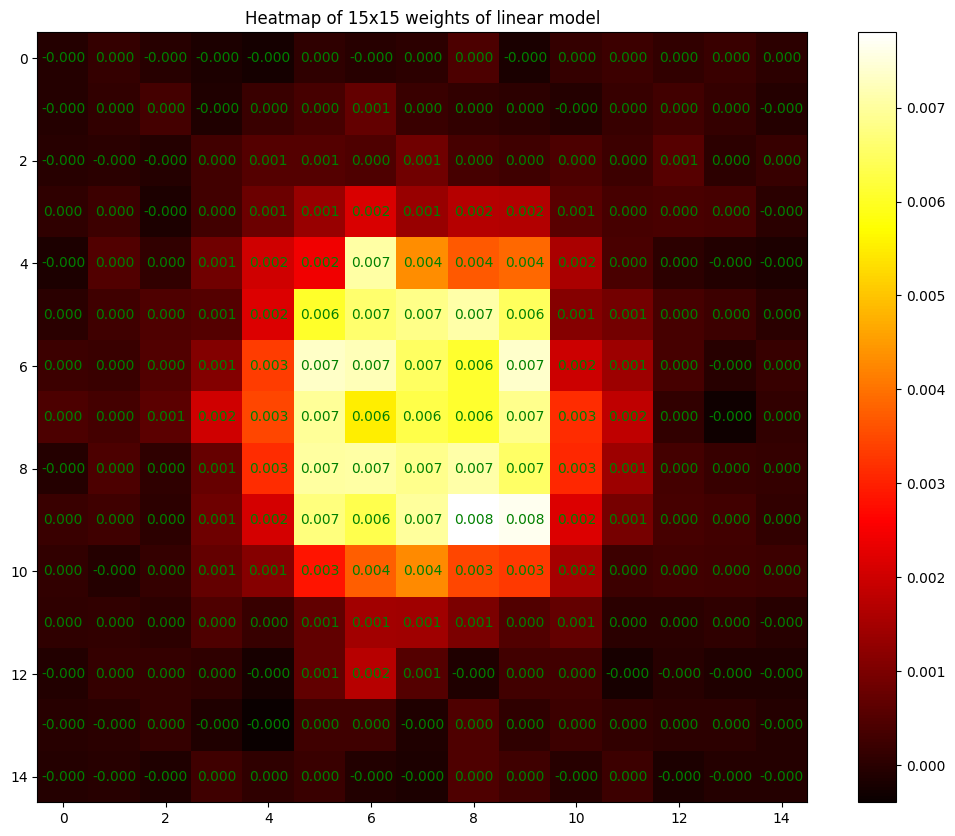

In [59]:
linear_weights = model.models[4][0].weight.mean(dim=0).data.flatten().cpu().reshape(15, 15)

plt.figure(figsize=(13, 10))
plt.imshow(linear_weights, cmap='hot', interpolation='nearest')
for i in range(linear_weights.shape[0]):
    for j in range(linear_weights.shape[1]):
        text = plt.text(j, i, f"{linear_weights[i, j]:.3f}",
                        ha="center", va="center", color="green")

plt.title("Heatmap of 15x15 weights of linear model")
plt.colorbar()
plt.show()

### Experiment 2

In [22]:
from config import load_config
import logging
from data import extract_dimensions, get_data
from model import get_model
from utils import get_loss_fn, number_of_weights, compute_metrics
import torch
import os
import matplotlib.pyplot as plt
import numpy as np


cfg, cfg_dict = load_config()

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.propagate = cfg.logging.info_prints

height, width = extract_dimensions(cfg.paths.data_file)

cfg.data.height = height
cfg.data.width = width

cfg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader, val_loader = get_data(cfg, logger)

model, optimizer, scheduler = get_model(cfg, logger, create_subdirs=False)

criterion_eng = get_loss_fn("MAE_E")
criterion_pos = get_loss_fn("RMSE")

INFO:__main__:Loading the data
INFO:__main__:Successfully loaded the data || Time elapsed: 0.224 s.
INFO:__main__:Loading the model
INFO:__main__:Current PyTorch seed: 15699192605957581189
INFO:__main__:Successfully loaded the model || Time elapsed: 0.021 s.


In [32]:
def eval_fn(
    model,
    train_loader,
    val_loader,
    criterion_eng,
    criterion_pos,
    cfg,
    logger,
):

    def pretty_metrics(metrics):
        result = ""
        for name, value in metrics.items():
            if len(result) > 0:
                result += " || "
            result += f"{name}: {value:0.4f}"
        return result

    alpha = cfg.training.eng_loss_weight

    model.eval()
    with torch.no_grad():
        train_total = torch.zeros((1,), device=cfg.device, dtype=torch.float32)
        train_eng = torch.zeros_like(train_total)
        train_pos = torch.zeros_like(train_total)

        for data, trg in train_loader:
            data = data.to(cfg.device)
            trg = trg.to(cfg.device)

            output = model(data)
            loss_eng = criterion_eng(output[:, 0], trg[:, 0])
            loss_pos = criterion_pos(output[:, 1:3], trg[:, 1:3])
            loss = alpha * loss_eng + (1 - alpha) * loss_pos

            train_total += loss.detach()
            train_eng += loss_eng.detach()
            train_pos += loss_pos.detach()

        train_total = (train_total / len(train_loader)).item()
        train_eng = (train_eng / len(train_loader)).item()
        train_pos = (train_pos / len(train_loader)).item()
        
        val_total = torch.zeros((1,), device=cfg.device, dtype=torch.float32)
        val_eng = torch.zeros_like(val_total)
        val_pos = torch.zeros_like(val_total)

        for data, trg in val_loader:
            data = data.to(cfg.device)
            trg = trg.to(cfg.device)

            output = model(data)
            loss_eng = criterion_eng(output[:, 0], trg[:, 0])
            loss_pos = criterion_pos(output[:, 1:3], trg[:, 1:3])
            loss = alpha * loss_eng + (1 - alpha) * loss_pos

            val_total += loss.detach()
            val_eng += loss_eng.detach()
            val_pos += loss_pos.detach()
        
        val_total = (val_total / len(val_loader)).item()
        val_eng = (val_eng / len(val_loader)).item()
        val_pos = (val_pos / len(val_loader)).item()

    logger.info(f"Train total: {train_total:0.4f} || Train eng: {train_eng:0.4f} || Train pos: {train_pos:0.4f}")
    logger.info(f"Val total: {val_total:0.4f} || Val eng: {val_eng:0.4f} || Val pos: {val_pos:0.4f}")

    val_outputs, val_targets, metrics, no_reduce_metrics = compute_metrics(
        model=model,
        val_loader=val_loader,
        cfg=cfg,
    )

    logger.info(f"Val metrics: {pretty_metrics(metrics)}")

    logger.info("=" * 80)

    return val_outputs.cpu().numpy(), val_targets.cpu().numpy(), metrics, no_reduce_metrics

INFO:__main__:Train total: 0.0209 || Train eng: 0.0127 || Train pos: 0.0292
INFO:__main__:Val total: 0.0210 || Val eng: 0.0127 || Val pos: 0.0294
INFO:__main__:Val metrics: RMSE_E eng: 0.0193 || MAE_E eng: 0.0127 || RR eng: -0.0006 || RR pos: 1.3614 || RMSE eng: 0.7909 || RMSE pos: 0.0295 || MSE eng: 0.6256 || MSE pos: 0.0009 || MAE eng: 0.5141 || MAE pos: 0.0192
INFO:__main__:================================================================================


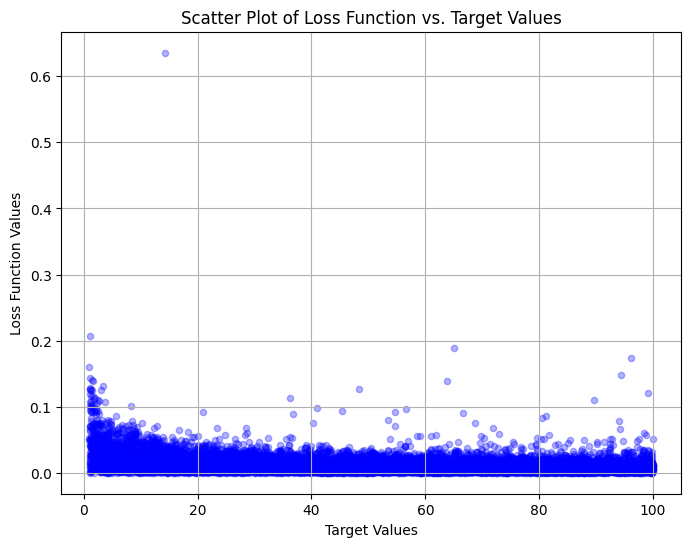

In [76]:
checkpoint_path = os.path.join(
    "checkpoints",
    f"{cfg.model.tag}_{height}x{width}",
    "run_8",
    "checkpoint.pth.tar"
)

checkpoint = torch.load(checkpoint_path, map_location=cfg.device)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])

val_outputs_1, val_targets_1, metrics_1, no_reduce_metrics_1 = eval_fn(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion_eng=criterion_eng,
    criterion_pos=criterion_pos,
    cfg=cfg,
    logger=logger,
)

plt.figure(figsize=(8, 6))
plt.scatter(val_targets_1[:, 0], no_reduce_metrics_1['MAE_E'], color='blue', alpha=0.3, s=20)
plt.xlabel('Target Values')
plt.ylabel('Loss Function Values')
plt.title('Scatter Plot of Loss Function vs. Target Values')
plt.grid(True)
plt.show()

INFO:__main__:Train total: 0.0246 || Train eng: 0.0134 || Train pos: 0.0358
INFO:__main__:Val total: 0.0245 || Val eng: 0.0133 || Val pos: 0.0357
INFO:__main__:Val metrics: RMSE_E eng: 0.0225 || MAE_E eng: 0.0133 || RR eng: 0.0003 || RR pos: 2.5000 || RMSE eng: 0.7605 || RMSE pos: 0.0358 || MSE eng: 0.5784 || MSE pos: 0.0013 || MAE eng: 0.5046 || MAE pos: 0.0243
INFO:__main__:================================================================================


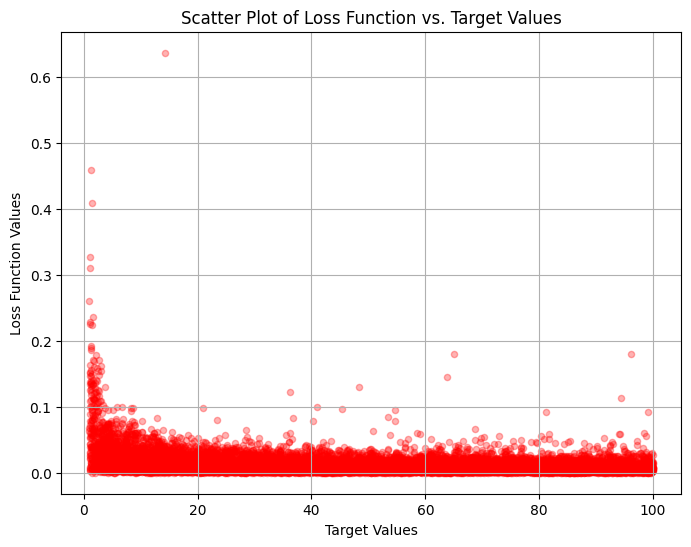

In [77]:
checkpoint_path = os.path.join(
    "checkpoints",
    f"{cfg.model.tag}_{height}x{width}",
    "run_9",
    "checkpoint.pth.tar"
)

checkpoint = torch.load(checkpoint_path, map_location=cfg.device)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])

val_outputs_2, val_targets_2, metrics_2, no_reduce_metrics_2 = eval_fn(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion_eng=criterion_eng,
    criterion_pos=criterion_pos,
    cfg=cfg,
    logger=logger,
)

plt.figure(figsize=(8, 6))
plt.scatter(val_targets_2[:, 0], no_reduce_metrics_2['MAE_E'], color='red', alpha=0.3, s=20)
plt.xlabel('Target Values')
plt.ylabel('Loss Function Values')
plt.title('Scatter Plot of Loss Function vs. Target Values')
plt.grid(True)
plt.show()

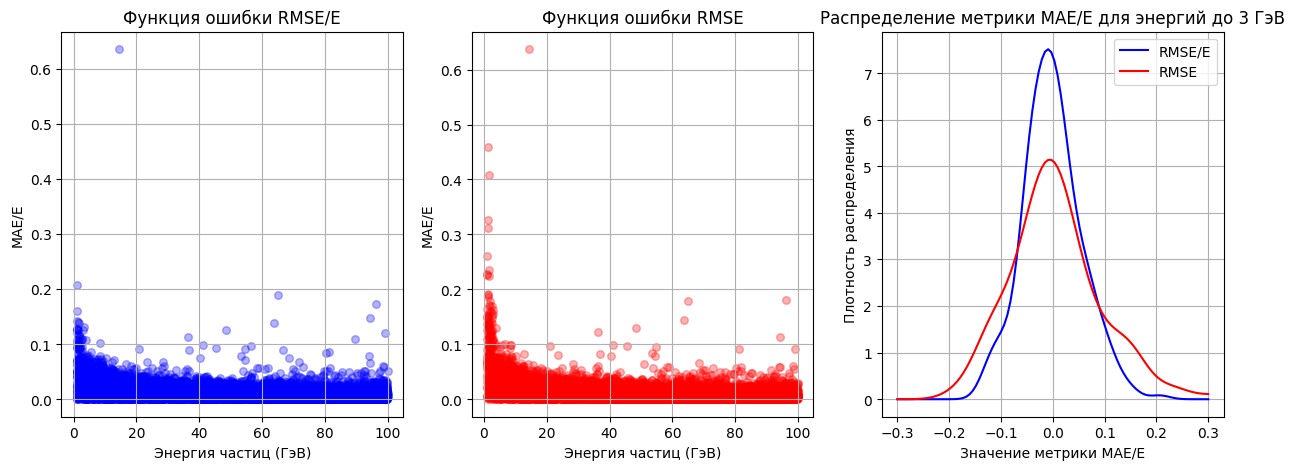

In [124]:
from scipy.stats import gaussian_kde

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(val_targets_1[:, 0], no_reduce_metrics_1['MAE_E'], color='blue', alpha=0.3, s=30)
plt.xlabel('Энергия частиц (ГэВ)')
plt.ylabel('MAE/E')
plt.title('Функция ошибки RMSE/E')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.scatter(val_targets_2[:, 0], no_reduce_metrics_2['MAE_E'], color='red', alpha=0.3, s=30)
plt.xlabel('Энергия частиц (ГэВ)')
plt.ylabel('MAE/E')
plt.title('Функция ошибки RMSE')
plt.grid(True)

plt.subplot(1, 3, 3)

max_trg = 3
target_values_1 = val_targets_1[:, 0]
loss_values_1 = no_reduce_metrics_1['RR']
filtered_loss_values_1 = loss_values_1[target_values_1 <= max_trg]

target_values_2 = val_targets_2[:, 0]
loss_values_2 = no_reduce_metrics_2['RR']
filtered_loss_values_2 = loss_values_2[target_values_2 <= max_trg]

kde_1 = gaussian_kde(filtered_loss_values_1)
x_vals_1 = np.linspace(-0.3, 0.3, 100)
plt.plot(x_vals_1, kde_1(x_vals_1), label='RMSE/E', color='blue')

kde_2 = gaussian_kde(filtered_loss_values_2)
x_vals_2 = np.linspace(-0.3, 0.3, 100)
plt.plot(x_vals_2, kde_2(x_vals_2), label='RMSE', color='red')
plt.xlabel('Значение метрики MAE/E')
plt.ylabel('Плотность распределения')
plt.title(f"Распределение метрики MAE/E для энергий до {max_trg} ГэВ")
plt.legend()
plt.grid(True)

# plt.tight_layout()
plt.show()